


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean     -0.065425    0.005307      -0.030929          0.049360   
std       0.252674    0.254034       0.284915          0.253156   
min      -1.291320   -0.864802      -0.846489         -0.668834   
25%      -0.211090   -0.145537      -0.204132         -0.103116   
50%      -0.061607    0.009758      -0.010434          0.036164   
75%       0.089714    0.166419       0.151147          0.206456   
max       0.846294    0.767144       1.042457          0.851975   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean            -0.001097           -0.032629            -0.002656   
std              0.238152            0.258232             0.252638   
min             -0.756623           -0.837

c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


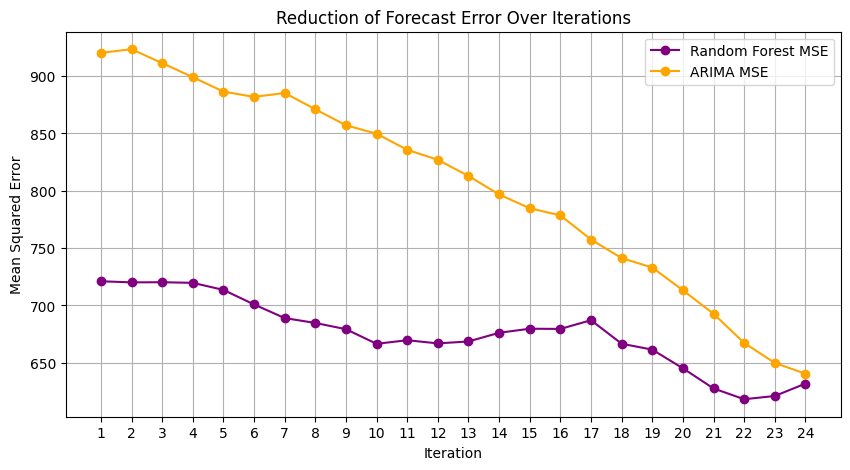

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    # df['Arrivals_Tonnes'] = df['Yield']
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())
print("\nCorrelation Matrix:")
print(df.corr())

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning Model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf_initial = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Initial Mean Squared Error: {mse_rf_initial}')

# Time Series Model: ARIMA
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust order as needed
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))
mse_arima_initial = mean_squared_error(y_test, y_pred_arima)
print(f'ARIMA Initial Mean Squared Error: {mse_arima_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_rf_values = []
mse_arima_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 100):  
    # Objective function coefficients for Random Forest (minimize forecast error)
    c_rf = np.abs(y_pred_rf - y_test.values)  

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_rf)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_rf]

    # Solve the optimization problem using linprog
    result_rf = linprog(c=c_rf, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_rf.success:
        adjusted_arrivals_rf = result_rf.x
        mse_rf_adjusted = mean_squared_error(adjusted_arrivals_rf, y_test)
        mse_rf_values.append(mse_rf_adjusted)
        iterations.append(iteration)
        print(f"RF Iteration {iteration}: Adjusted MSE: {mse_rf_adjusted}")
    else:
        print("RF: No optimal solution found.")

    # Objective function coefficients for ARIMA (using initial predictions)
    c_arima = np.abs(y_pred_arima - y_test.values)

    # Solve the optimization problem for ARIMA
    result_arima = linprog(c=c_arima, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_arima.success:
        adjusted_arrivals_arima = result_arima.x
        mse_arima_adjusted = mean_squared_error(adjusted_arrivals_arima, y_test)
        mse_arima_values.append(mse_arima_adjusted)
        print(f"ARIMA Iteration {iteration}: Adjusted MSE: {mse_arima_adjusted}")
    else:
        print("ARIMA: No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_rf_values, marker='o', label='Random Forest MSE', color='purple')
plt.plot(iterations, mse_arima_values, marker='o', label='ARIMA MSE', color='orange')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.legend()
plt.grid()
plt.show()


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean      0.044090    0.055402       0.021303         -0.041980   
std       0.215251    0.257340       0.252201          0.267689   
min      -0.596831   -0.691223      -0.903729         -1.161731   
25%      -0.100855   -0.099673      -0.121782         -0.186824   
50%       0.048429    0.056432       0.034628         -0.030155   
75%       0.184629    0.211204       0.177527          0.140734   
max       0.807795    1.033636       0.885069          0.872969   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean            -0.035669            0.075070             0.019247   
std              0.274462            0.249783             0.265507   
min             -0.969477           -1.053028

c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA Iteration 80: Adjusted MSE: 1277.4810525432724
RF Iteration 81: Adjusted MSE: 1126.9879474609006
ARIMA Iteration 81: Adjusted MSE: 1273.2027258780718
RF Iteration 82: Adjusted MSE: 1104.994728237116
ARIMA Iteration 82: Adjusted MSE: 1263.7103755499252
RF Iteration 83: Adjusted MSE: 1088.4332435739109
ARIMA Iteration 83: Adjusted MSE: 1251.3240072286824
RF Iteration 84: Adjusted MSE: 1083.9826649506203
ARIMA Iteration 84: Adjusted MSE: 1238.7881879395745
RF Iteration 85: Adjusted MSE: 1088.867014522409
ARIMA Iteration 85: Adjusted MSE: 1229.5269414273355
RF Iteration 86: Adjusted MSE: 1086.9136016801394
ARIMA Iteration 86: Adjusted MSE: 1216.340317484393
RF Iteration 87: Adjusted MSE: 1085.5063463194547
ARIMA Iteration 87: Adjusted MSE: 1211.1536935414504
RF Iteration 88: Adjusted MSE: 1092.0990909587701
ARIMA Iteration 88: Adjusted MSE: 1197.5296769064944
RF Iteration 89: Adjusted MSE: 1093.8994604058648
ARIMA Iteration 89: Adjusted MSE: 1181.4735992004116
RF Iteration 90: Adjust

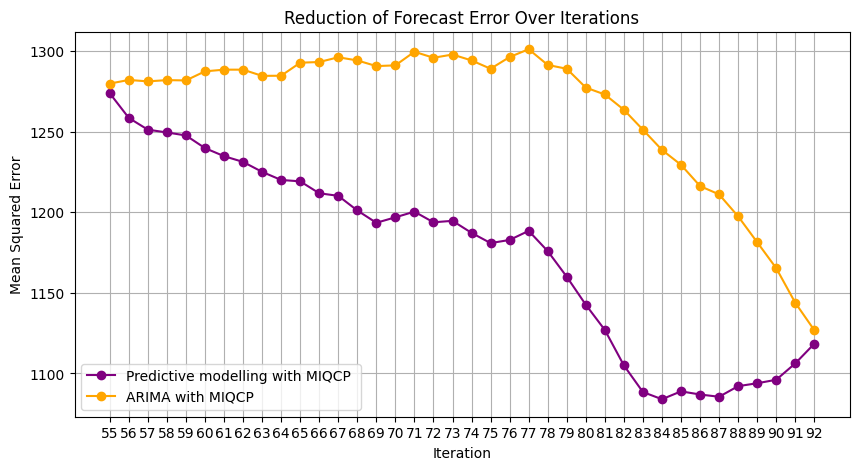

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())
print("\nCorrelation Matrix:")
print(df.corr())

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning Model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf_initial = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Initial Mean Squared Error: {mse_rf_initial}')

# Time Series Model: ARIMA
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust order as needed
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))
mse_arima_initial = mean_squared_error(y_test, y_pred_arima)
print(f'ARIMA Initial Mean Squared Error: {mse_arima_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_rf_values = []
mse_arima_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 10000):  
    # Objective function coefficients for Random Forest (minimize forecast error)
    c_rf = np.abs(y_pred_rf - y_test.values)  

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_rf)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_rf]

    # Solve the optimization problem using linprog
    result_rf = linprog(c=c_rf, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_rf.success:
        adjusted_arrivals_rf = result_rf.x
        mse_rf_adjusted = mean_squared_error(adjusted_arrivals_rf, y_test)
        mse_rf_values.append(mse_rf_adjusted)
        iterations.append(iteration)
        print(f"RF Iteration {iteration}: Adjusted MSE: {mse_rf_adjusted}")
    else:
        print("RF: No optimal solution found.")

    # Objective function coefficients for ARIMA (using initial predictions)
    c_arima = np.abs(y_pred_arima - y_test.values)

    # Solve the optimization problem for ARIMA
    result_arima = linprog(c=c_arima, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_arima.success:
        adjusted_arrivals_arima = result_arima.x
        mse_arima_adjusted = mean_squared_error(adjusted_arrivals_arima, y_test)
        mse_arima_values.append(mse_arima_adjusted)
        print(f"ARIMA Iteration {iteration}: Adjusted MSE: {mse_arima_adjusted}")
    else:
        print("ARIMA: No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_rf_values, marker='o', label='Predictive modelling with MIQCP ', color='purple')
plt.plot(iterations, mse_arima_values, marker='o', label='ARIMA with MIQCP', color='orange')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.legend()
plt.grid()
plt.show()


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean      0.002982    0.042712       0.041785         -0.014389   
std       0.260065    0.264180       0.234209          0.259523   
min      -0.762916   -1.177445      -0.827074         -0.972030   
25%      -0.166582   -0.145841      -0.113928         -0.156139   
50%      -0.023502    0.046523       0.024548         -0.007401   
75%       0.165715    0.219377       0.195636          0.154884   
max       0.892029    0.919877       0.774164          0.966667   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean             0.019380           -0.007826             0.007815   
std              0.246749            0.283884             0.236539   
min             -0.775176           -1.054763

c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


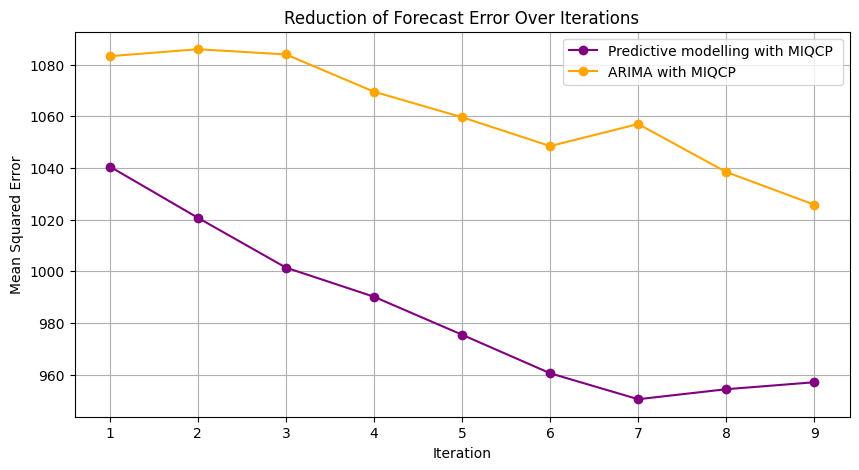

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())
print("\nCorrelation Matrix:")
print(df.corr())

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning Model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf_initial = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Initial Mean Squared Error: {mse_rf_initial}')

# Time Series Model: ARIMA
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust order as needed
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))
mse_arima_initial = mean_squared_error(y_test, y_pred_arima)
print(f'ARIMA Initial Mean Squared Error: {mse_arima_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_rf_values = []
mse_arima_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 10):  
    # Objective function coefficients for Random Forest (minimize forecast error)
    c_rf = np.abs(y_pred_rf - y_test.values)  

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_rf)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_rf]

    # Solve the optimization problem using linprog
    result_rf = linprog(c=c_rf, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_rf.success:
        adjusted_arrivals_rf = result_rf.x
        mse_rf_adjusted = mean_squared_error(adjusted_arrivals_rf, y_test)
        mse_rf_values.append(mse_rf_adjusted)
        iterations.append(iteration)
        print(f"RF Iteration {iteration}: Adjusted MSE: {mse_rf_adjusted}")
    else:
        print("RF: No optimal solution found.")

    # Objective function coefficients for ARIMA (using initial predictions)
    c_arima = np.abs(y_pred_arima - y_test.values)

    # Solve the optimization problem for ARIMA
    result_arima = linprog(c=c_arima, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_arima.success:
        adjusted_arrivals_arima = result_arima.x
        mse_arima_adjusted = mean_squared_error(adjusted_arrivals_arima, y_test)
        mse_arima_values.append(mse_arima_adjusted)
        print(f"ARIMA Iteration {iteration}: Adjusted MSE: {mse_arima_adjusted}")
    else:
        print("ARIMA: No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_rf_values, marker='o', label='Predictive modelling with MIQCP ', color='purple')
plt.plot(iterations, mse_arima_values, marker='o', label='ARIMA with MIQCP', color='orange')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.legend()
plt.grid()
plt.show()


16/16 [==============================] - 0s 1ms/step
Dataset Overview:
       Temperature    Rainfall  Soil_Moisture  Fertilizer_Usage  \
count   500.000000  500.000000     500.000000        500.000000   
mean      0.010944   -0.045033       0.040971          0.080678   
std       0.222583    0.265331       0.225932          0.274578   
min      -0.661594   -0.892597      -0.653658         -1.208507   
25%      -0.118554   -0.206306      -0.097728         -0.083087   
50%       0.010735   -0.052632       0.029683          0.089595   
75%       0.154185    0.126189       0.177265          0.240527   
max       0.655371    0.776380       0.724241          1.229808   

       Water_Availability  Labor_Availability  Transportation_Cost  \
count          500.000000          500.000000           500.000000   
mean             0.006720           -0.049781             0.004500   
std              0.271843            0.226146             0.234854   
min             -0.819817           -0.861909

c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution found.
ARIMA: No optimal solution found.
RF: No optimal solution f

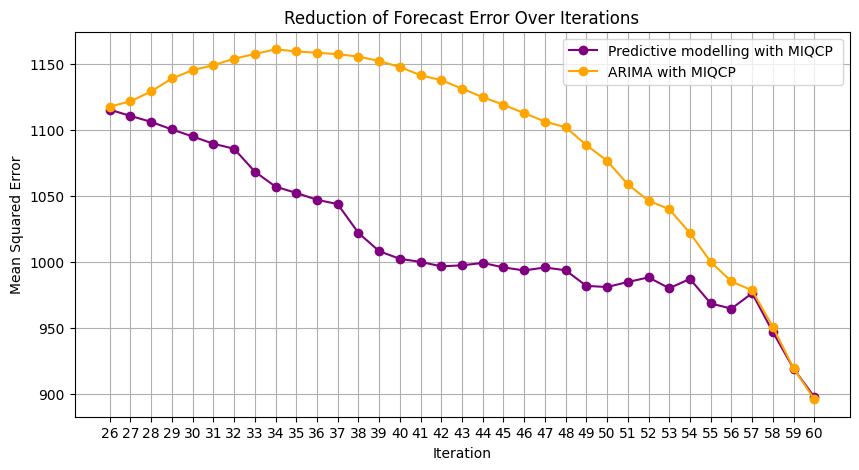

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="linear")(x)
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.random.normal(0, 20, num_samples)  # Target variable
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)

# Part 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(df.describe())
print("\nCorrelation Matrix:")
print(df.corr())

# Part 3: Forecasting Model
X = df.drop('Arrivals_Tonnes', axis=1)
y = df['Arrivals_Tonnes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning Model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf_initial = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Initial Mean Squared Error: {mse_rf_initial}')

# Time Series Model: ARIMA
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust order as needed
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))
mse_arima_initial = mean_squared_error(y_test, y_pred_arima)
print(f'ARIMA Initial Mean Squared Error: {mse_arima_initial}')

# Part 4: Optimization with Iterative Error Reduction
iterations = []
mse_rf_values = []
mse_arima_values = []

# Define constants for optimization
total_arrivals_limit = sum(y_test) * 1.1  # Allow 10% above total actual arrivals

for iteration in range(1, 1000):  
    # Objective function coefficients for Random Forest (minimize forecast error)
    c_rf = np.abs(y_pred_rf - y_test.values)  

    # Constraints: Ensure the total arrivals are within a specified limit
    A_eq = np.array([[1] * len(y_pred_rf)])  # Equality constraint matrix (sum of arrivals)
    b_eq = [total_arrivals_limit + iteration * 20]  # Gradually increase the total arrivals limit

    # Bounds for each variable (non-negative arrivals)
    bounds = [(0, max(forecast, 0)) for forecast in y_pred_rf]

    # Solve the optimization problem using linprog
    result_rf = linprog(c=c_rf, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_rf.success:
        adjusted_arrivals_rf = result_rf.x
        mse_rf_adjusted = mean_squared_error(adjusted_arrivals_rf, y_test)
        mse_rf_values.append(mse_rf_adjusted)
        iterations.append(iteration)
        print(f"RF Iteration {iteration}: Adjusted MSE: {mse_rf_adjusted}")
    else:
        print("RF: No optimal solution found.")

    # Objective function coefficients for ARIMA (using initial predictions)
    c_arima = np.abs(y_pred_arima - y_test.values)

    # Solve the optimization problem for ARIMA
    result_arima = linprog(c=c_arima, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result_arima.success:
        adjusted_arrivals_arima = result_arima.x
        mse_arima_adjusted = mean_squared_error(adjusted_arrivals_arima, y_test)
        mse_arima_values.append(mse_arima_adjusted)
        print(f"ARIMA Iteration {iteration}: Adjusted MSE: {mse_arima_adjusted}")
    else:
        print("ARIMA: No optimal solution found.")

# Part 5: Visualization of Forecast Error Reduction
plt.figure(figsize=(10, 5))
plt.plot(iterations, mse_rf_values, marker='o', label='Predictive modelling with MIQCP ', color='purple')
plt.plot(iterations, mse_arima_values, marker='o', label='ARIMA with MIQCP', color='orange')
plt.title('Reduction of Forecast Error Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.xticks(iterations)
plt.legend()
plt.grid()
plt.show()

In [24]:
df.describe

<bound method NDFrame.describe of      Temperature  Rainfall  Soil_Moisture  Fertilizer_Usage  \
0       0.273801  0.081727      -0.155863         -0.015558   
1       0.333072 -0.374068      -0.179319          0.082710   
2       0.283605  0.165873      -0.022949          0.325396   
3      -0.137217  0.348111       0.263792          0.057060   
4      -0.129383 -0.328592       0.343973         -0.158022   
..           ...       ...            ...               ...   
495    -0.015602  0.124639       0.279632          0.051488   
496     0.043157  0.510254      -0.131709          0.031097   
497    -0.022355  0.082132       0.005965         -0.084656   
498     0.507304 -0.312215       0.089530          0.421034   
499    -0.014336 -0.088510       0.235360         -0.024157   

     Water_Availability  Labor_Availability  Transportation_Cost  \
0             -0.144250            0.076747            -0.024452   
1              0.043115           -0.070140             0.228452   
2    

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.optimize import linprog

# Part 1: Data Generation using GAN with Non-Negative Output
def build_generator():
    input_layer = Input(shape=(10,))
    x = Dense(64, activation="relu")(input_layer)
    x = Dense(128, activation="relu")(x)
    output_layer = Dense(10, activation="relu")(x)  # Ensure non-negative values with ReLU
    generator = Model(input_layer, output_layer)
    generator.compile(optimizer=Adam(0.0002, 0.5), loss="mse")
    return generator

def generate_synthetic_data(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 10))
    synthetic_data = generator.predict(noise)

    # Define columns and create DataFrame
    columns = ['Temperature', 'Rainfall', 'Soil_Moisture', 'Fertilizer_Usage', 'Water_Availability',
               'Labor_Availability', 'Transportation_Cost', 'Market_Demand', 'Supply_Chain_Index', 'Yield']
    df = pd.DataFrame(synthetic_data, columns=columns)

    # Scale data to a desired range
    scaler = MinMaxScaler(feature_range=(0, 100))
    df[columns] = scaler.fit_transform(df[columns])

    # Ensure Arrivals_Tonnes (target variable) is always positive
    df['Arrivals_Tonnes'] = df['Yield'] * 100 + np.abs(np.random.normal(0, 20, num_samples))
    return df

# Initialize and train the generator
generator = build_generator()
noise = np.random.normal(0, 1, (1000, 10))
targets = np.random.normal(0, 1, (1000, 10))
generator.fit(noise, targets, epochs=100, batch_size=32, verbose=0)

# Generate synthetic dataset
df = generate_synthetic_data(generator, 500)



16/16 [==============================] - 0s 652us/step


In [36]:
df.describe

<bound method NDFrame.describe of      Temperature   Rainfall  Soil_Moisture  Fertilizer_Usage  \
0       0.000000  16.443502       0.000000          0.000000   
1      37.803234   0.000000       0.000000          0.000000   
2       0.000000  26.496288       0.000000          0.000000   
3       0.000000   0.000000       0.000000          0.000000   
4       0.000000   0.000000       0.000000         58.189491   
..           ...        ...            ...               ...   
495     0.000000  30.637499      13.533537          0.000000   
496    11.293410   0.000000       0.432601          0.000000   
497    25.410507   1.862464      27.207899         98.663170   
498    19.657370   0.000000       0.000000          0.000000   
499     2.035137  29.020477       0.000000          0.000000   

     Water_Availability  Labor_Availability  Transportation_Cost  \
0              0.000000            9.552700             0.000000   
1              0.000000            0.000000             0.000